In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
datafile = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/presel/JetHT_Data_UL/JetHT_Run2018_full/ntuple.root"
tree = Tree(datafile)

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


In [4]:
trih_index = combinations(6, [2,2,2])
def get_trih(tree):
  jets = tree[['jet_pt','jet_m','jet_eta','jet_phi','jet_btag']]

  btagordered = ak.argsort(-jets.jet_btag, axis=-1)[:,:6]
  jets = jets[btagordered]

  jet_p4 = build_p4(jets, prefix='jet', use_regressed=False)
  trih_p4 = (jet_p4[:,trih_index[:,:,0]]+jet_p4[:,trih_index[:,:,1]])

  trih_m = ak.from_regular(ak.from_regular(trih_p4.m, axis=-1),axis=-2)
  trih_pt = ak.from_regular(ak.from_regular(trih_p4.pt, axis=-1), axis=-2)

  trih_asym = (trih_m[:,:,0]-trih_m[:,:,1])**2 + (trih_m[:,:,0]-trih_m[:,:,1])**2 + (trih_m[:,:,1]-trih_m[:,:,2])**2
  minarg = ak.argmin(trih_asym, axis=-1, keepdims=True)

  higgs_m = trih_m[minarg][:,0]
  higgs_pt = trih_pt[minarg][:,0]

  ptordered = ak.argsort(-higgs_pt, axis=-1)

  return ak.zip(
    {
      'higgs_pt':higgs_pt[ptordered],
      'higgs_m':higgs_m[ptordered]
    }
  )

In [7]:
?chunk_method

Signature:
chunk_method(
    array: awkward.highlevel.Array,
    array_method: Callable,
    batches=25,
    events=None,
    report=False,
) -> awkward.highlevel.Array
Docstring:
Apply a method on an array in chunks. The final result is then concatenated together.

Args:
    array (ak.Array): Awkward Array like structure
    array_method (Callable): Method that takes an array as the first argument and returns an array
    batches (int, optional): Number of batches to chunk the array into. Defaults to None.
    events (int, optional): Approximate number of events per chunk. Defaults to None.
    report (bool, optional): Gives TQDM reporting. Defaults to True.

Returns:
    ak.Array: Awkward Array that is a concatenation of the results of the array_method
File:      /uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/utils/utils.py
Type:      function


In [5]:
trih = chunk_method(tree, get_trih, batches=25, report=True)
tree.extend(trih)

100%|██████████| 25/25 [05:52<00:00, 14.09s/it]


100%|██████████| 2/2 [00:08<00:00,  4.36s/it]


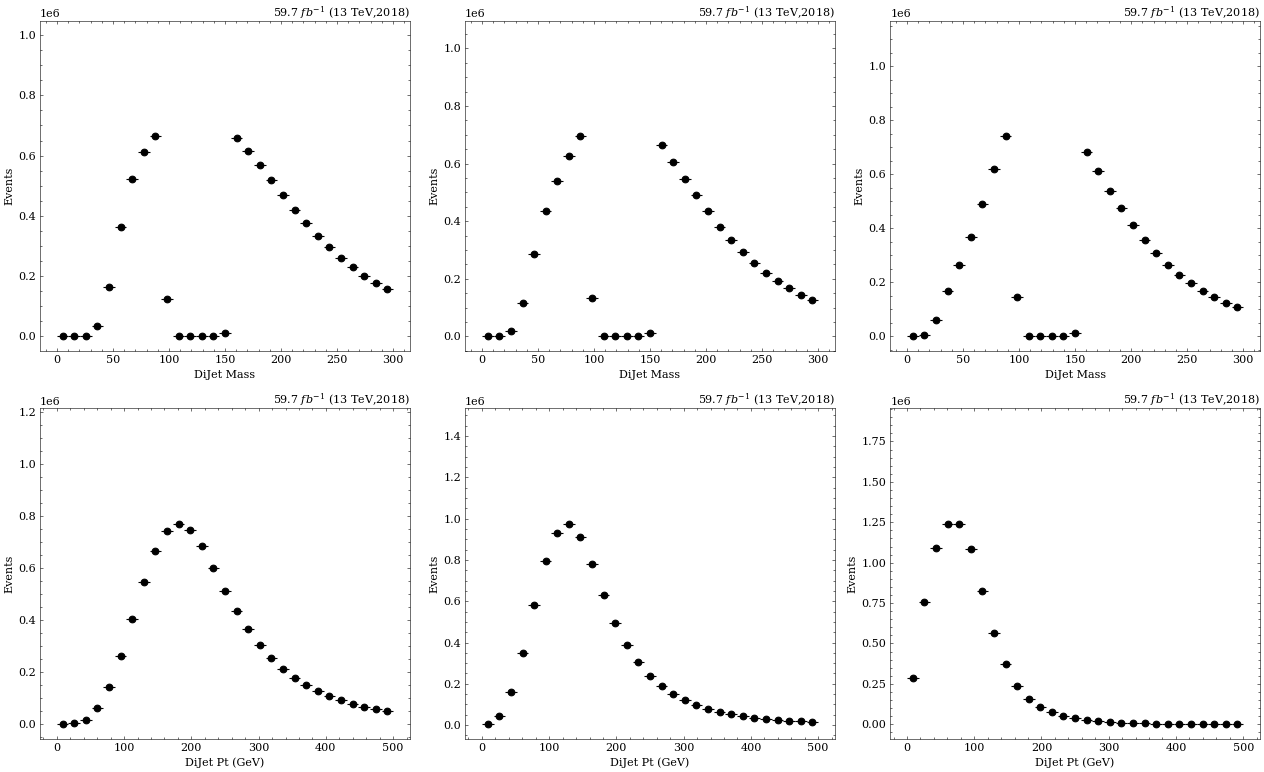

In [6]:
fig, axs = study.get_figax(6, dim=(-1,3))
for i in range(3):
  study.quick(
    [tree],
    masks=lambda t : np.abs(t.higgs_m[:,i]-125)>30,
    varlist=[f'higgs_m[:,{i}]',f'higgs_pt[:,{i}]'],
    figax=(fig, axs[:,i])
  )